# Model3

## Long Short-Term Memory

An LSTM (Long Short-Term Memory) is a type of artificial neural network that can remember patterns or sequences over a long period of time. Imagine you're trying to understand a story that someone is telling you, word by word. To make sense of the story, you need to remember not just the current word but also the words that came before it. This is similar to what an LSTM does.

Think of an LSTM as a series of connected "memory cells," each cell responsible for remembering a part of the sequence. As information passes through these cells, they can "learn" which parts are important and should be remembered, and which parts can be forgotten. This is useful when dealing with data that has a time component, like speech, music, or a series of text messages.

![3](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/LSTM3.webp>)

![2](<https://raw.githubusercontent.com/jh4578/5293finalproject/main/_build/html/_images/LSTM2.webp>)

Although it looks complex, you will easily understand it with one example. 
Suppose we are going to take a sequence of exams: high school math --> Calculus --> Linear Algebra --> … At this point, we just finished our high school math exam, and we are studying for the Calculus exam. 
 
The memory we have right now is $C_{t-1}$ in the left corner, it includes plenty of knowledge related to high school math. $h_{t-1}$ in the left bottom represents ourselves, $X_t$ represents the textbooks of Calculus. 

When we read the Calculus textbooks ($h_{t-1}$ and $X_t$ merge), we realized that some of our memory is irrelevant to Calculus, such as geometry. Since our memory space is limited, we need to forget that irrelevant knowledge, which is shown by the forget gate $f_t$. 
 
Then we discover some Calculus information, and we need to memorize it. Again, since our memory space is limited, we don’t want to learn knowledge irrelevant to the exam, such as the history of Calculus. That’s what the yellow tanh and $i_t$ do. $i_t$ takes charge of learning knowledge, while tanh filters the relevant knowledge. 
 
Finally, we are going to take the exam. In the exam, we need to grab specific knowledge (not all knowledge) from our memory to solve specific questions. That’s how the red tanh work, it filters our memory and grabs specific knowledge. After we finished the exam, we will receive an output score h_t in the upper right corner. We can use that score to check how good is our study process. Also, we will pass our memory $C_t$ to the next cell. 

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/jh4578/5293finalproject/main/GOOG_update.csv',date_parser = True)

In [ ]:
data.index = data['Date']
data.drop(columns = ['Date','High','Low','Close','Adj Close'], inplace = True)


In [ ]:
data.head()

,Open,Volume,CPI,Core CPI,gdp,Unemployment_rate,m1,DFF,M2
Date,,,,,,,,,
2004-09-01,2.557912,4270113667,2.240201,197.5,12305.307,5.4,1343.475,1.605000,6337.150
2004-10-01,3.257789,10321258145,2.237219,197.9,12305.307,5.5,1348.975,1.760968,6351.475
2004-11-01,4.820681,11145383635,2.301213,198.3,12305.307,5.4,1373.940,1.932000,6395.220
2004-12-01,4.531764,5835483147,2.313886,198.6,12527.214,5.4,1390.450,2.156129,6448.450
2005-01-01,4.916571,8237356337,2.315890,199.0,12527.214,5.3,1374.700,2.279355,6407.200


Here we define a function organize train and test data set. We will use the data from 2004 to 2019 to train the model and the other used for test. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define the lookback period and split the data into train and test sets
lookback = 3
train_size = int(len(data) * 0.7713004484304933)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - lookback:]

In [ ]:
def create_sequences(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(train_data, lookback)
X_test, Y_test = create_sequences(test_data, lookback)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(lookback, data.shape[1])),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Make predictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Invert the normalization
Y_train_pred = scaler.inverse_transform(np.hstack([Y_train_pred, train_data[lookback:, 1:]]))[:, 0]
Y_test_pred = scaler.inverse_transform(np.hstack([Y_test_pred, test_data[lookback:, 1:]]))[:, 0]
Y_train_actual = scaler.inverse_transform(train_data[lookback:])[:, 0]
Y_test_actual = scaler.inverse_transform(test_data[lookback:])[:, 0]

# Calculate the Mean Squared Error (MSE)
mse_train = mean_squared_error(Y_train_actual, Y_train_pred)
mse_test = mean_squared_error(Y_test_actual, Y_test_pred)
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

# Calculate the Mean Absolute Error (MAE)
mae_train = mean_absolute_error(Y_train_actual, Y_train_pred)
mae_test = mean_absolute_error(Y_test_actual, Y_test_pred)
print(f"Train MAE: {mae_train:.4f}")
print(f"Test MAE: {mae_test:.4f}")

2/2 [==============================] - 0s 5ms/step
Train MSE: 3.5094
Test MSE: 374.8578
Train MAE: 1.3293
Test MAE: 14.6765


Here both the MSE and MAE for both training data and testing data are smaller than the MSE of the other two models, which indicates a better of fit.

In [ ]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Open', 'prediction'])
    actual_pred['Open'] = data.loc['2019':,'Open'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Open']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

(374.85776, <Axes: xlabel='Date'>)

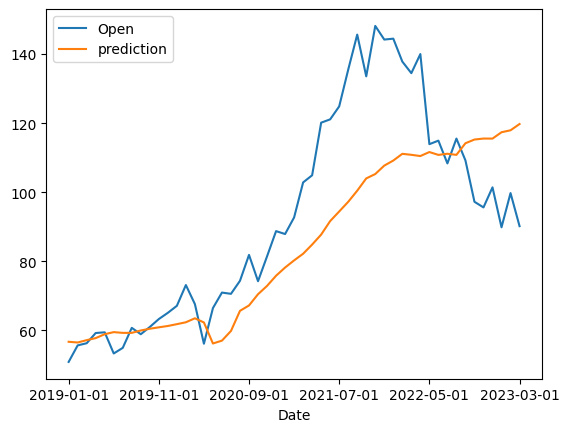

In [ ]:
pred = Y_test_pred.reshape(-1,1)
actual_pred_plot(pred)

## Model Interpretation

LSTM is not a interpretable model, so I am going to use SHAP(SHapley Additive exPlanations) to approximate the contributions of each feature to the model's predictions for this model and data.

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
def lstm_flatten_input(X):
    n_samples = X.shape[0]
    X_flat = X.reshape(n_samples, -1)
    return X_flat



In [ ]:
X_train_flat = lstm_flatten_input(X_train)
X_test_flat = lstm_flatten_input(X_test)

def model_wrapper(X_flat):
    X = X_flat.reshape((-1, lookback, data.shape[1]))
    return model.predict(X)

explainer = shap.KernelExplainer(model_wrapper, X_train_flat[:100])


4/4 [==============================] - 0s 3ms/step


In [ ]:
# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_flat, nsamples=50)
shap_values = np.array(shap_values)
shap_values = shap_values.reshape((-1, lookback, data.shape[1]))
mean_shap_values = np.mean(np.sum(np.abs(shap_values), axis=1), axis=0)

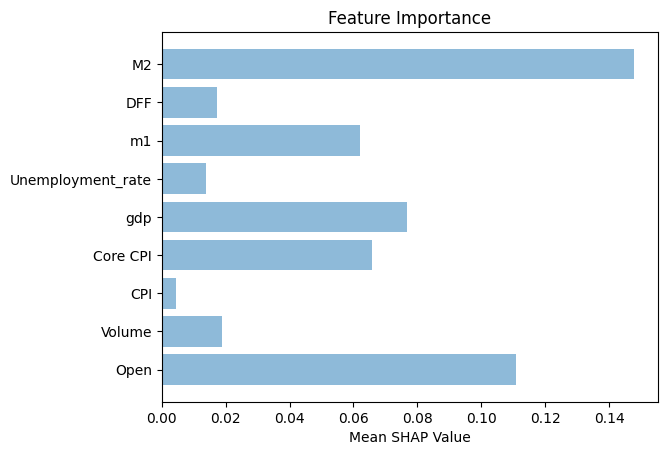

In [ ]:
features = ['Open', 'Volume', 'CPI', 'Core CPI', 'gdp', 'Unemployment_rate', 'm1', 'DFF', 'M2']
y_pos = np.arange(len(features))
plt.barh(y_pos, mean_shap_values, align='center', alpha=0.5)
plt.yticks(y_pos, features)
plt.xlabel('Mean SHAP Value')
plt.title('Feature Importance')
plt.show()

According to the plot: M2, previous stock price, and GDP are the top three features correlated with future stock prices. On the other hand, CPI, unemployment rate and federal funds rate are not significant variables to predict the Google stock price.

# Conclusion

LSTM fits the data better than SARIMAX and Linear Regression. That is because LSTM used both previous stock price and other features to make predictions, while LR does not focus on the correlation between nearby stock price and SARIMAX focus more on the correlations. 

However, LSTM is still far from perfect, future adjustments are needed to improve the fit.

## Reference

https://colah.github.io/posts/2015-08-Understanding-LSTMs/
